## Imports et fonctions

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as ddb
import datetime as dt
import folium
import unidecode
from sklearn.metrics.pairwise import haversine_distances


In [ ]:
rfm_total = pd.read_csv("data/rfm_total.csv")
rfm_data = pd.read_csv("data/rfm_data.csv")

### RFM total

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# rfm_total = getRfmNewData('201701', '201808')

num_clusters = 3

encoder = OrdinalEncoder()
rfm_total[["fav_categ", "fav_payment_type"]] = encoder.fit_transform(rfm_total[["fav_categ", "fav_payment_type"]])

# Standarisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_total.drop(['customer_unique_id', 'period'], axis=1))

kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42)
kmeans.fit(df_scaled)

rfm_total['Cluster'] = kmeans.labels_

### RFM Futur

In [ ]:
encoder = OrdinalEncoder()
rfm_data[["fav_categ", "fav_payment_type"]] = encoder.fit_transform(rfm_data[["fav_categ", "fav_payment_type"]])

# Standarisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_data.drop(['customer_unique_id', 'period','last_order'], axis=1))

kmeans_data = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42)
kmeans_data.fit(df_scaled)

rfm_data['Cluster'] = kmeans_data.labels_

# Importation des données

In [160]:
ari_df = pd.DataFrame(columns=['Period', 'ARI'])

periods = [
    '201701',
    '201702',
    '201703',
    '201704',
    '201705',
    '201706',
    '201707',
    '201708',
]

periods = periods[::-1]

cumulative_df = None

mois = 0

# Pour chaque échantillon temporel, effectuer le clustering et calculer l'ARI
for period in periods:
    # rfm_i =  getRfmNewData(start_period, end_period)
    rfm_i = rfm_total[rfm_total["period"] == period]

    if cumulative_df is None:
        cumulative_df = rfm_data.copy()
    else:
        cumulative_df = pd.concat((cumulative_df, rfm_i), ignore_index=True)


    encoder = OrdinalEncoder()
    cumulative_df[["fav_categ", "fav_payment_type"]] = encoder.fit_transform(cumulative_df[["fav_categ", "fav_payment_type"]])

    # Réduction de la variabilité avec PCA
    # pca = PCA(n_components=4)  # Réduisez le nombre de composantes selon votre besoin
    # train_pca = pca.fit_transform(rfm_i[columns])
    train_pca = cumulative_df.drop(["customer_unique_id", "period"], axis=1)

    # Prétraiter les données
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_pca)

    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42)
    kmeans.fit(train_scaled)

    cluster_labels = kmeans.predict(train_scaled)

    # origin_labels = kmeans_origin.predict(cumulative_df)
    # origin_labels = kmeans_all.predict(train_scaled)

    ari = adjusted_rand_score(cumulative_df["Cluster"], cluster_labels)

    # Ajouter l'ARI au DataFrame
    ari_df = pd.concat([ari_df, pd.DataFrame([[mois, ari]], columns=['Period', 'ARI'])], ignore_index=True)

    mois += 1 



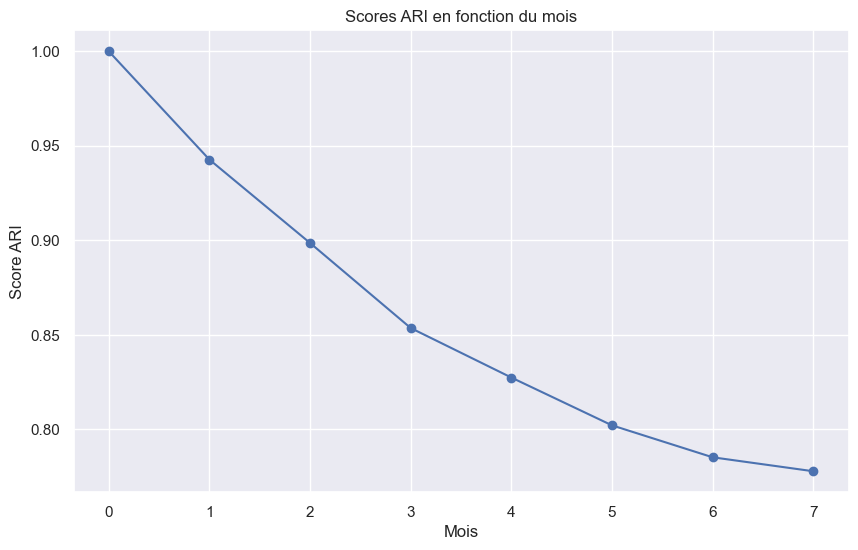

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(ari_df['Period'], ari_df['ARI'], marker='o', linestyle='-')
plt.title('Scores ARI en fonction du mois')
plt.xlabel('Mois')
plt.ylabel('Score ARI')
plt.grid(True)
plt.show()
